# Investigate new holdout stuff

In this NB, we use the embeddings generated in the NB:
`Graph embedding using SkipGram 20201012 homogeneous graph training.ipynb`
md5 hash: 261f9f7b0137263728c292a1a878d7baf3f875f3

kg-covid-19:
version 20201012

ensmallen-graph
Version: 0.4.4

embiggen
Version: 0.6.0

In [1]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')  # identical to 0.4.3 except for addition of some methods like get_edge_id()
assert(get_distribution("embiggen").version == '0.6.0')

### Define all files and URLs up top here

In [2]:
import os

exp_name = "80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001"

s3_path = "s3://kg-hub-public-data/embeddings/20201012/"  # keep trailing slash

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201012")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201012")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201012/SkipGram_80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# params
seed = 42
train_percentage = 0.8
patience = 5
min_delta = 0.0001

In [3]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

In [4]:
# get the graphs, if necessary

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

## Retrieve the embeddings

In [5]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

## Edge embeddings
We will compute the edge embeddings using all the 5 available methods:

- Hadamart: an element-wise product
- Mean
- Norm L1
- Norm L2
- Concatenation

## Loading the graph

In [6]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = edges_file,
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = nodes_file,
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.67 ms


In [7]:
from ensmallen_graph import EnsmallenGraph
 
graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=447766,  # should be = or > than actual number
    edges_number=42000000,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

{'undirected_edges_number': '15611957',
 'self_loops_number': '480',
 'has_weights': 'false',
 'unique_edge_types_number': '0',
 'name': 'Graph',
 'edges_number': '31223434',
 'density': '0.010673045865565448',
 'directed': 'false',
 'degree_mean': '69.73158748096104',
 'unique_node_types_number': '42',
 'singletons': '8355',
 'has_edge_types': 'false',
 'self_loops_rate': '0.000015373068830289457',
 'nodes_number': '447766',
 'has_node_types': 'true'}

In [16]:
import numpy as np
embedding = np.load(embedding_file, allow_pickle=True)
assert(len(embedding) == len(pos_training.get_node_types()))

## Defining holdouts and tasks data generator
We are going to create the same edge embeddings as in the training of the embeddings.

In [9]:
%%time
# to use a given edge_type in positive edges:
# install latest ensmallen_graph
# use edge_types param (a list of strings) - validation set will be only these edge types
pos_training, pos_validation = graph.connected_holdout(train_size=train_percentage, random_state=seed)

CPU times: user 3min 25s, sys: 676 ms, total: 3min 26s
Wall time: 3min 24s


In [10]:
%%time
# To force neg edges to use nodes from a given graph
# install latest ensmallen
# seed_graph param - upload TSV with this great
neg_training, neg_validation = graph.sample_negatives(
   random_state=seed,
   only_from_same_component=True,
   negatives_number=graph.get_edges_number(),
   # allow_selfloops=False  # this has been removed in new ensmallen - this will instead be inferred from the graph itself
).random_holdout(random_state=seed, train_size=train_percentage)

CPU times: user 8min 51s, sys: 1min 34s, total: 10min 26s
Wall time: 7min 26s


In [11]:
%%time
# To force neg edges to use nodes from a given graph
# install latest ensmallen
# seed_graph param - upload TSV with this great
neg_training_old, neg_validation_old = graph.sample_negatives(
   random_state=seed,
   only_from_same_component=False,
   negatives_number=graph.get_edges_number(),
   # allow_selfloops=False  # this has been removed in new ensmallen - this will instead be inferred from the graph itself
).random_holdout(random_state=seed, train_size=train_percentage)

CPU times: user 5min 53s, sys: 1min 5s, total: 6min 58s
Wall time: 4min 50s


In [18]:
import numpy as np
from tqdm import tqdm
embedding = np.load(embedding_file, allow_pickle=True)
from embiggen import GraphTransformer, EdgeTransformer

def make_edge_embeddings(graph: EnsmallenGraph, embedding: np.ndarray, method="average") -> np.ndarray:
    # create graph transformer object to convert graphs into edge embeddings
    transformer = GraphTransformer(method)
    transformer.fit(embedding) # pass node embeddings to be used to create edge embeddings
    return transformer.transform(graph)

edge_embeddings = [
   make_edge_embeddings(graph, embedding)
   for graph in tqdm([pos_training, neg_training, neg_training_old])
]

100%|██████████| 3/3 [01:22<00:00, 27.55s/it]


0it [00:00, ?it/s]

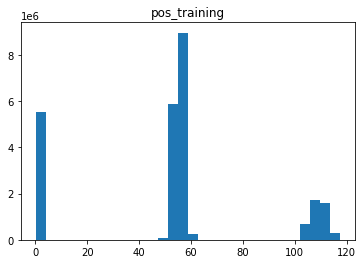

1it [00:05,  5.77s/it]

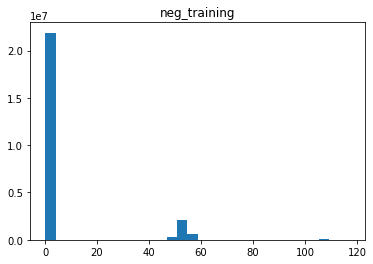

2it [00:11,  5.77s/it]

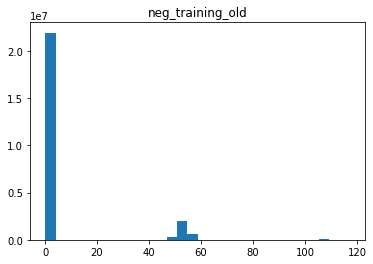

3it [00:17,  5.75s/it]


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy.linalg import norm
%matplotlib inline

lab = ['pos_training', 'neg_training', 'neg_training_old']
for i, graph in tqdm(enumerate(edge_embeddings)):
    plt.hist(np.linalg.norm(graph, axis=1), density=False, bins=30)  # `density=False` makes counts
    plt.title(lab[i])
    plt.show()